In [ ]:
# useful commands to setup a conda environment with all necessary packages:
# $ conda create -n scanpy
# $ conda activate scanpy
# $ conda install -c conda-forge scanpy python-igraph leidenalg
# $ conda install pooch
# $ conda install -c conda-forge --name scanpy ipykernel -y
# $ conda install bioconda::scrublet
# $ conda install -c conda-forge ipywidgets

We are following this tutorial: https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html

The data used was collected from bone marrow mononuclear cells (BMMCs) of healthy human donors and was part of [openproblem's NeurIPS 2021 benchmarking dataset](https://openproblems.bio/competitions/neurips_2021/) `Luecken2021`. The samples were measured using the 10X Multiome Gene Expression and Chromatin Accessability kit. 


In [1]:
import scanpy as sc
import anndata as ad
import pooch

In [2]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [3]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

/usr/people/barth/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/people/barth/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/people/barth/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/people/barth/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/usr/people/barth/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

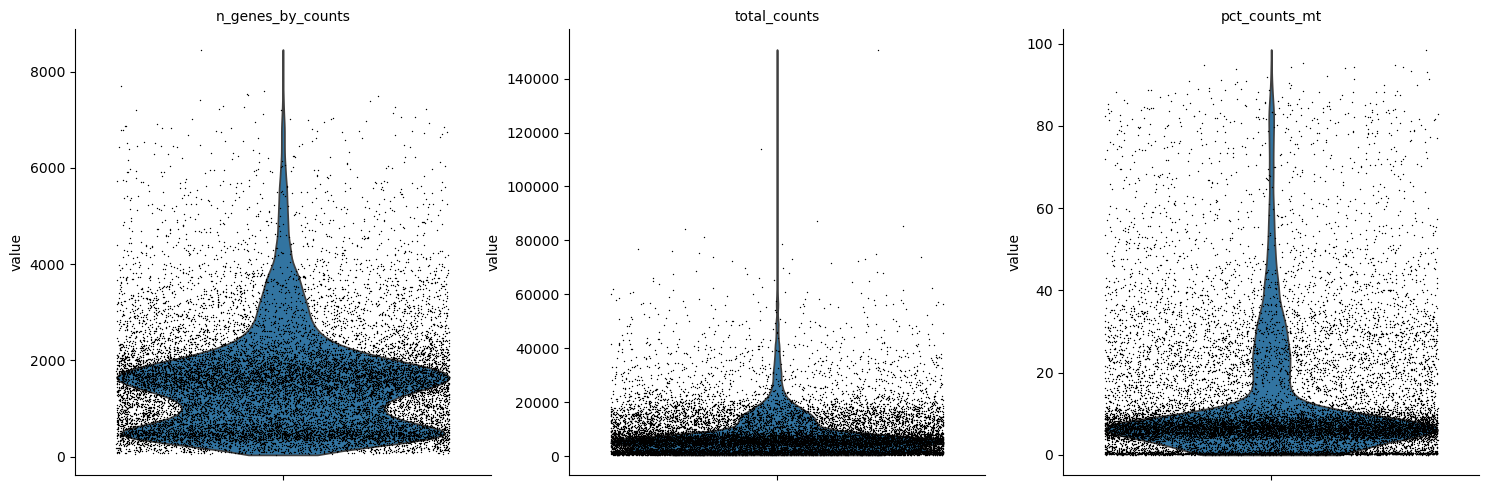

In [7]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

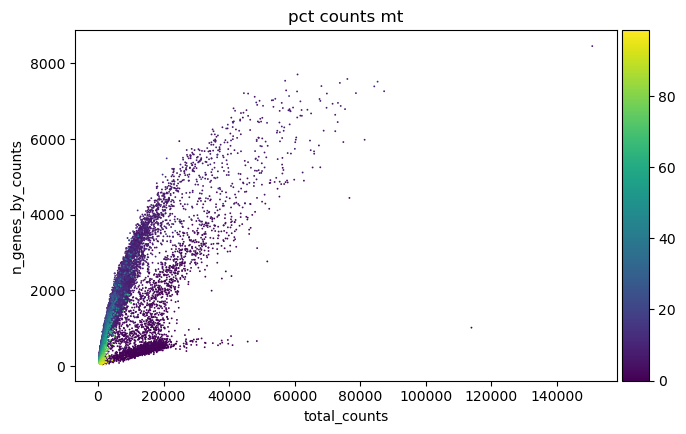

In [8]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [9]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [10]:
sc.pp.scrublet(adata, batch_key="sample") # can take few minutes

In [13]:
# Get doublet scores (continuous values)
doublet_scores = adata.obs['doublet_score'].values

# Get predicted doublet labels (boolean)
predicted_doublets = adata.obs['predicted_doublet'].values

In [19]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [25]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

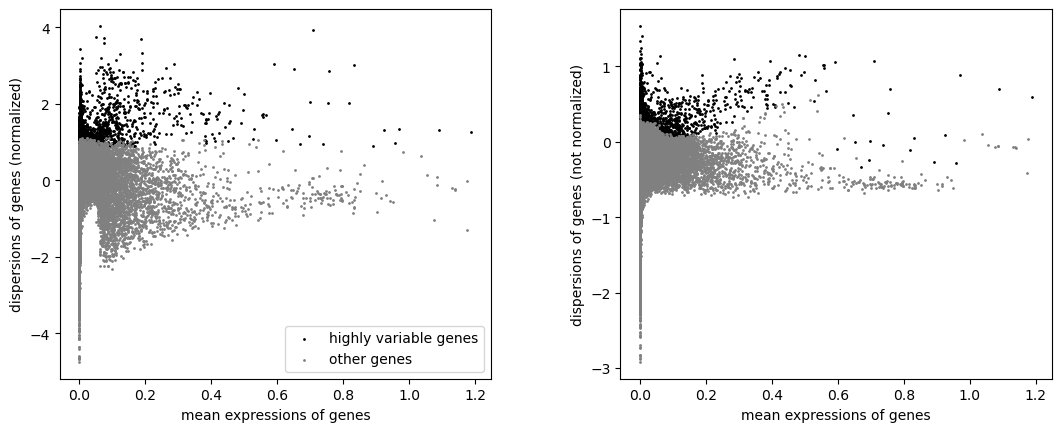

In [26]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
sc.pl.highly_variable_genes(adata)

In [27]:
sc.tl.pca(adata)

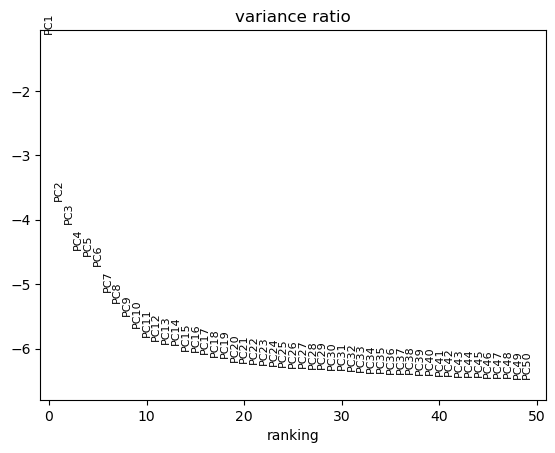

In [28]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [29]:
pca_data = adata.obsm['X_pca']

In [30]:
sc.pp.neighbors(adata)

In [31]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

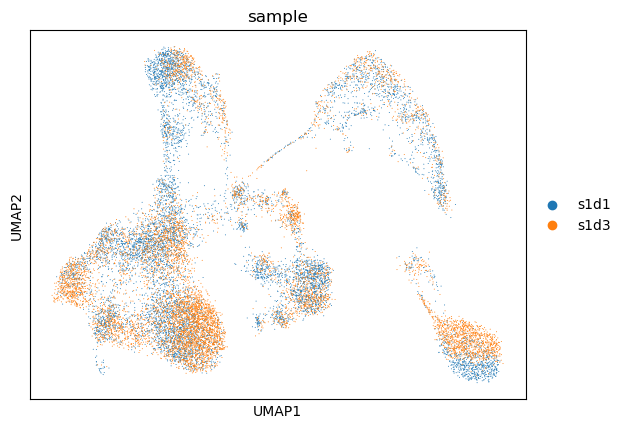

In [32]:
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

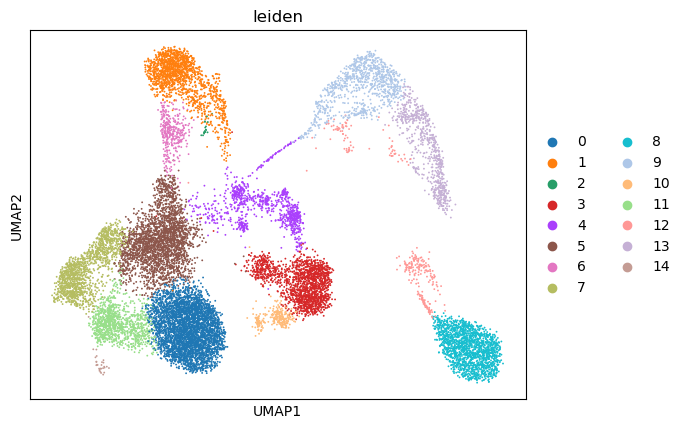

In [33]:
sc.pl.umap(adata, color=["leiden"])

In [34]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

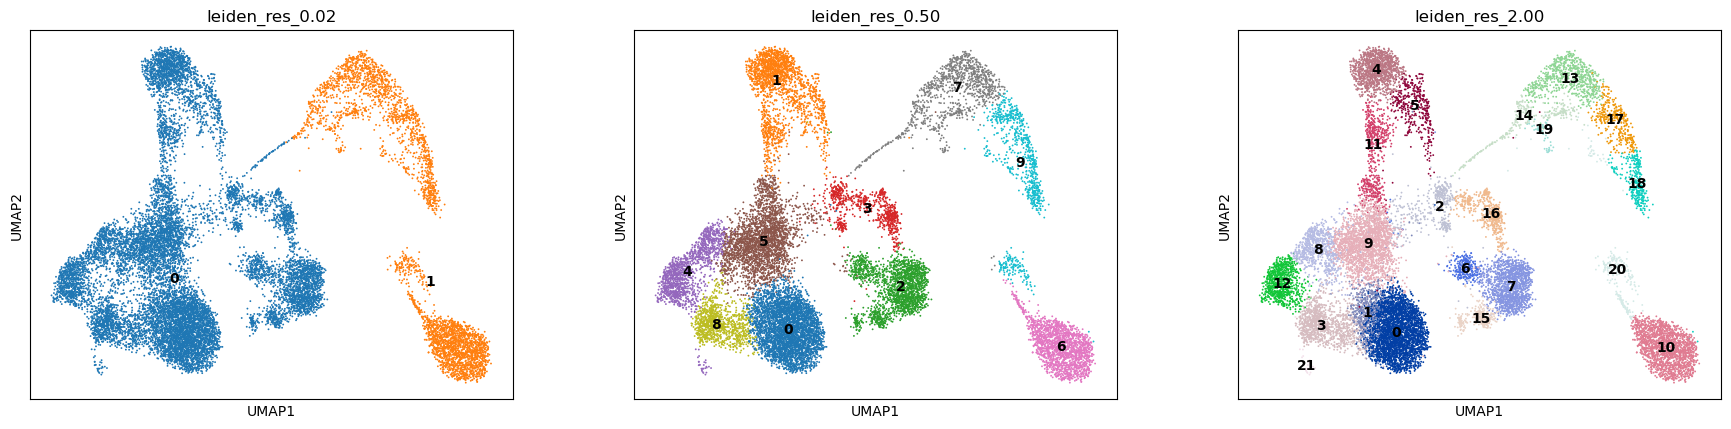

In [35]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)

In [36]:
leiden_labels = adata.obs['leiden_res_0.50'].values

In [40]:
leiden_labels = np.array(leiden_labels,dtype=np.int64)

In [41]:
import pickle

# Storing
def save_object(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

In [42]:
BMMC_object = {'pca_data': pca_data, 'doublet_scores': doublet_scores, 'predicted_doublets': predicted_doublets, 'leiden_labels': leiden_labels}
save_object(BMMC_object, "BMMC_object.pkl")

In [ ]:
import numpy as np
import pickle

def create_bmmc_cell_labels(adata, save_path='bmmc_cell_types.pkl'):
    """
    Create cell type labels for BMMC data using mutually exclusive marker genes.
    
    Parameters:
    -----------
    adata : AnnData
        Scanpy AnnData object containing BMMC single-cell data
    save_path : str
        Path to save the pickle file
    
    Returns:
    --------
    dict : Dictionary containing cell type labels and expression data
    """
    
    # Define marker genes for major BMMC cell types
    # These are chosen to be largely mutually exclusive
    marker_genes = {
        'HSC_Primitive': 'CD34',      # Hematopoietic stem/progenitor cells
        'B_cells': 'CD19',            # B cells and B cell precursors
        'T_cells': 'CD3E',            # T cells (CD3E is more specific than CD3)
        'Monocytes': 'CD14',          # Monocytes/macrophages
        'NK_cells': 'NKG7',           # NK cells
        'Erythroid': 'HBB',           # Erythroid lineage (hemoglobin beta)
        'Megakaryocytes': 'PPBP',     # Platelets/megakaryocytes
        'Neutrophils': 'ELANE'        # Neutrophil elastase - neutrophil lineage
    }
    
    print("Extracting expression data for marker genes...")
    
    # Extract expression arrays for each marker gene
    expression_data = {}
    available_genes = []
    
    for cell_type, gene in marker_genes.items():
        if gene in adata.var.index:
            expr_array = adata[:, gene].X.toarray().flatten()
            expression_data[gene] = expr_array
            available_genes.append((cell_type, gene))
            print(f"✓ {gene} ({cell_type}): {(expr_array > 0).sum()} expressing cells")
        else:
            print(f"✗ {gene} ({cell_type}): Not found in dataset")
    
    if not available_genes:
        raise ValueError("No marker genes found in the dataset!")
    
    # Calculate thresholds for each gene (75th percentile of expressing cells)
    thresholds = {}
    binary_masks = {}
    
    print("\nCalculating expression thresholds...")
    for cell_type, gene in available_genes:
        expr_array = expression_data[gene]
        expressing_cells = expr_array[expr_array > 0]
        
        if len(expressing_cells) > 0:
            threshold = np.percentile(expressing_cells, 75)  # Top 25% of expressing cells
        else:
            threshold = 0.1  # Fallback threshold
            
        thresholds[gene] = threshold
        binary_masks[gene] = expr_array > threshold
        
        print(f"  {gene}: threshold = {threshold:.3f}, {binary_masks[gene].sum()} positive cells")
    
    # Create cell type labels
    n_cells = adata.n_obs
    cell_type_labels = np.full(n_cells, 'Other', dtype='<U20')
    
    # Assign labels based on marker expression
    print("\nAssigning cell type labels...")
    for cell_type, gene in available_genes:
        if gene in binary_masks:
            mask = binary_masks[gene]
            cell_type_labels[mask] = cell_type
            print(f"  {cell_type}: {mask.sum()} cells")
    
    # Check for co-expression conflicts
    total_positive = np.zeros(n_cells, dtype=int)
    for gene in binary_masks:
        total_positive += binary_masks[gene].astype(int)
    
    co_expressing = total_positive > 1
    print(f"\nCells with co-expression: {co_expressing.sum()} out of {n_cells} ({100*co_expressing.mean():.1f}%)")
    
    # Resolve conflicts by assigning to highest expressing gene
    if co_expressing.any():
        print("Resolving conflicts by highest expression...")
        conflict_indices = np.where(co_expressing)[0]
        
        for idx in conflict_indices:
            # Get expression levels for all marker genes in this cell
            expressions = {}
            for cell_type, gene in available_genes:
                if gene in expression_data:
                    expressions[cell_type] = expression_data[gene][idx]
            
            # Assign to cell type with highest expression
            if expressions:
                best_cell_type = max(expressions.keys(), key=lambda x: expressions[x])
                cell_type_labels[idx] = best_cell_type
    
    # Create final data package
    cell_type_data = {
        'cell_type_labels': cell_type_labels,
        'expression_arrays': expression_data,
        'thresholds': thresholds,
        'marker_genes': dict(available_genes),
        'cell_counts': dict(zip(*np.unique(cell_type_labels, return_counts=True))),
        'n_cells': n_cells,
        'co_expression_rate': float(co_expressing.mean())
    }
    
    # Create integer labels for easier processing
    unique_labels = np.unique(cell_type_labels)
    label_mapping = {label: i for i, label in enumerate(unique_labels)}
    integer_labels = np.array([label_mapping[label] for label in cell_type_labels])
    
    cell_type_data['integer_labels'] = integer_labels
    cell_type_data['label_mapping'] = label_mapping
    
    # Save to pickle file
    with open(save_path, 'wb') as f:
        pickle.dump(cell_type_data, f)
    
    print(f"\nCell type distribution:")
    for cell_type, count in cell_type_data['cell_counts'].items():
        print(f"  {cell_type}: {count} cells ({100*count/n_cells:.1f}%)")
    
    print(f"\nData saved to: {save_path}")
    return cell_type_data

# Alternative function for more refined HSC/progenitor classification
def create_bmmc_labels_with_hsc_subtypes(adata, save_path='bmmc_detailed_cell_types.pkl'):
    """
    Create BMMC cell labels with more detailed HSC/progenitor classification.
    Uses CD34/CD38 combination for stem cell hierarchy.
    """
    
    # Check if CD34 and CD38 are available for HSC subtyping
    has_cd34 = 'CD34' in adata.var.index
    has_cd38 = 'CD38' in adata.var.index
    
    if has_cd34 and has_cd38:
        print("Creating detailed HSC/progenitor labels using CD34/CD38...")
        
        cd34_expr = adata[:, 'CD34'].X.toarray().flatten()
        cd38_expr = adata[:, 'CD38'].X.toarray().flatten()
        
        # Define thresholds
        cd34_thresh = np.percentile(cd34_expr[cd34_expr > 0], 75)
        cd38_thresh = np.percentile(cd38_expr[cd38_expr > 0], 75)
        
        cd34_pos = cd34_expr > cd34_thresh
        cd38_pos = cd38_expr > cd38_thresh
        
        # HSC hierarchy based on CD34/CD38 expression
        hsc_primitive = cd34_pos & (~cd38_pos)  # CD34+/CD38- (most primitive)
        hsc_committed = cd34_pos & cd38_pos     # CD34+/CD38+ (committed progenitors)
        
        print(f"  Primitive HSCs (CD34+/CD38-): {hsc_primitive.sum()} cells")
        print(f"  Committed progenitors (CD34+/CD38+): {hsc_committed.sum()} cells")
        
        # You can extend this with additional markers for lineage commitment
        # For example, add erythroid (CD71), myeloid (CD33), etc.
        
    else:
        print("CD34 or CD38 not available, using basic classification...")
        return create_bmmc_cell_labels(adata, save_path)

# Example usage:
"""
# Load your BMMC data
import scanpy as sc
adata = sc.read_h5ad('your_bmmc_data.h5ad')

# Create cell type labels
cell_type_data = create_bmmc_cell_labels(adata)

# Load the saved data later
with open('bmmc_cell_types.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
    
labels = loaded_data['cell_type_labels']
expressions = loaded_data['expression_arrays']

# Use in plotting
adata.obs['predicted_cell_type'] = labels
sc.pl.umap(adata, color='predicted_cell_type')
"""